Packages:

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.integrate import odeint
import scipy.odr
import scipy
import statistics as st
import math
from matplotlib.pylab import *
from tabulate import tabulate
from matplotlib.ticker import StrMethodFormatter


In [2]:

species=['ketene','ethanol','acetaldehyde','acetone','aceticacid','acetic anhydride','H2O','CO2','N2','H2']
ketene,ethanol,acetaldehyde,acetone,aceticacid,aceticanhydride,h2o,co2,n2,h2=range(10)
M=[42,46,44,58,60,102,18,44,28,2]
C=[2,2,2,3,2,4]
RRF=[0.279,0.279,0.415,0.27,0.56,0.46]

def pp(y,M,P):
    #partial pressure calculations
    Pi=(y/M)/sum(y/M)*P
    return Pi


skiprowz = 2
filenames = ['ni_025.txt','Ni_050.txt', 'ni_1.txt', 'ni_2.txt']
data = {}

gcat_values = [0.0100, 0.010, 0.010, 0.010]

for i, name in enumerate(filenames):
    A = np.loadtxt(name, skiprows=skiprowz, unpack=True, usecols=(1,2,3,4,5,6,))
    t = (np.loadtxt(name, skiprows=skiprowz, unpack=True, usecols=(0))) / 60
    T = np.loadtxt(name, skiprows=skiprowz, unpack=True, usecols=(7)) 
    H2f, N2f, AAf = np.loadtxt(name, skiprows=skiprowz, unpack=True, usecols=(8,9,10))
    t = t - t[0]
    gcat = [gcat_values[i]] * T.shape[0]  # getting gcat as array

    H2w = H2f / 22400 * M[h2]  # ml/min til g/min
    N2w = N2f / 22400 * M[n2]
    AAw = AAf / 1000 * 1.05  # ml/min -> 1050 mg/ml
    WHSV = AAw / gcat * 60
    Fin = H2w + N2w + AAw

    N2wout = N2w / (H2w + N2w + AAw)
    H2wout = H2w / (H2w + N2w + AAw)
    AAwout = AAw / (H2w + N2w + AAw)

    Afrac = A
    for i in range(A.shape[1]):
        Afrac[:,i] = A[:,i] / sum(A[:,i])
    Afrac = Afrac.transpose()
    Wfrac = Afrac * RRF
    Mfrac = Wfrac * C * 12 / M[0:6]
    MH2O, MCO2 = [np.zeros(A.shape[1])] * 2

    MH2O = Mfrac[:,0] + Mfrac[:,1] + Mfrac[:,2] + Mfrac[:,3] + 1 * Mfrac[:,5]
    MCO2 = Mfrac[:,3]

    Mfrac = np.c_[Mfrac, MH2O, MCO2]
    W = Mfrac
    for i in range(Mfrac.shape[0]):
        W[i,:] = Mfrac[i,:] * M[0:8] / (sum(Mfrac[i,:] * M[0:8])) * AAwout[i]
    W = np.c_[W, N2wout, H2wout]

    w0 = np.zeros([W.shape[0], W.shape[1]])
    w0[:,aceticacid], w0[:,h2], w0[:,n2] = AAwout, H2wout, N2wout
    Pout = np.zeros([W.shape[0], W.shape[1]])
    Pin = np.zeros([W.shape[0], W.shape[1]])
    for i in range(W.shape[0]):
        Pout[i,:] = pp(W[i,:], M, 1)
        Pin[i,:] = pp(w0[i,:], M, 1)

    conversion = (w0[:,aceticacid] - W[:,aceticacid]) / w0[:,aceticacid] * 100
    r = np.zeros([W.shape[0], W.shape[1]])
    for i in range(r.shape[0]):
        r[i,:] = W[i,:] * Fin[i] / M / gcat[i] * 10**6  # micromol/gcat/h
    rt = r / 10**6 / 3600

    
    for i in range(len(t)):
        if rt[i,acetone]>0.8e-6:
            rt[i,acetone]=rt[i-1,acetone]

    # Calculate selectivity for acetone
    desired_product = acetone
    total_products = np.sum(W[:, :len(species) - 2], axis=1)  # Sum of all product weight fractions excluding N2 and H2

    selectivity = W[:, desired_product] / total_products

    """print(f"File: {name}")
    print("Time [h]  Selectivity")
    for j in range(len(t)):
        print(f"{t[j]:.2f}      {selectivity[j]:.4f}")"""

    """
    print(f"File: {name}")
    print("Time [h]  Conversion [%]")
    for j in range(len(t)):
        print(f"{t[j]:.2f}      {conversion[j]:.2f}")

    """
    # dictionary
    data[name] = {'t': t, 'rt_acetone': rt[:, acetone]}

    
    



FileNotFoundError: ni_025.txt not found.

In [ ]:
temperatures = [300,310,320,330,340,350]

def calculate_intercept_slope(filename, temperature):
    data = np.loadtxt(filename, skiprows=2)
    time, temperature_data, acetone_reaction_rate = data[:, 0] / 60, data[:, 7], data[:, 4] / 10**6 / 3600 
    mask = np.isclose(temperature_data, temperature, atol=1)
    time_temp, acetone_reaction_rate_temp = time[mask], acetone_reaction_rate[mask]
    x_regression, y_regression = time_temp[6:], acetone_reaction_rate_temp[6:]
    A = np.c_[x_regression, np.ones(len(x_regression))]
    beta = np.linalg.lstsq(A, y_regression, rcond=None)[0]
    return beta[1], beta[0]

def plot_acetone_formation_rate(temperatures, filenames):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharey='all')
    for idx, temp in enumerate(temperatures):
        intercepts = [calculate_intercept_slope(filename, temp)[0] for filename in filenames]
        beta_matrix = np.array(intercepts).reshape(-1, 1)
        x_values = np.arange(len(beta_matrix))
        custom_labels = ['Cu', '3:1 CuFe', '1:1 CuFe', '1:3 CuFe', 'Fe', 'Ni']
        ax = axs[idx // 3, idx % 3]
        ax.plot(x_values, beta_matrix, marker='o', linestyle='None', color='black')
        ax.set_xticks(x_values)
        ax.set_xticklabels(custom_labels, rotation=0, ha='center')
        ax.set_ylabel('r(0)', rotation=0, ha='right')
        ax.set_title(f'{temp}°C')
        ax.grid(True)
    plt.tight_layout()
    plt.show()


#plot_acetone_formation_rate(temperatures, filenames)

slopes_list = []

for temp in temperatures:
    slopes_temp = []
    for filename in filenames:
        intercept, slope = calculate_intercept_slope(filename, temp)
        slopes_temp.append(slope)
    slopes_list.append(slopes_temp)


IndexError: list index out of range

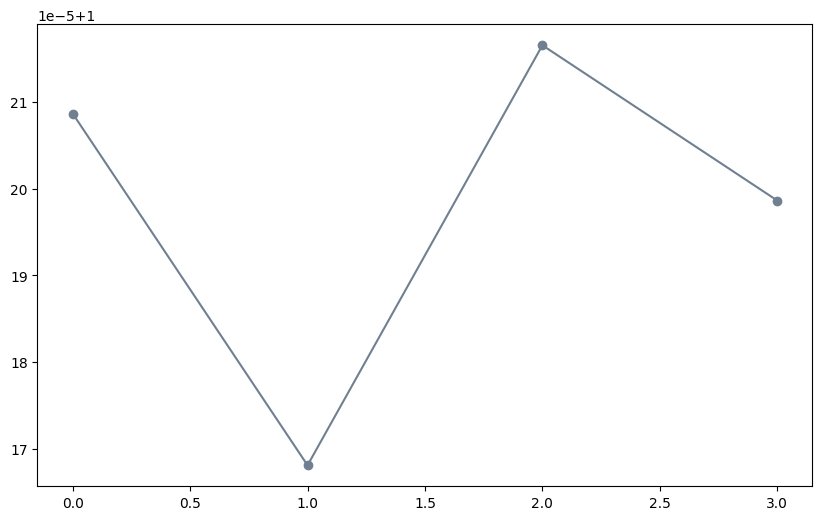

In [ ]:
def calculate_intercept(filename, temperature):
    data = np.loadtxt(filename, skiprows=2)

    time = data[:, 0] / 60  # time to hours
    temperature_data = data[:, 7] 
    acetone_reaction_rate = data[:, 4] / 10**6 / 3600 

    mask = np.isclose(temperature_data, temperature, atol=1) 

    acetone_reaction_rate_temp = acetone_reaction_rate[mask]
    time_temp = time[mask]

    x_regression = time_temp[6:]
    y_regression = acetone_reaction_rate_temp[6:]

    A = np.c_[x_regression, np.ones(len(x_regression))]
    beta = np.linalg.lstsq(A, y_regression, rcond=None)[0]
    intercept = beta[1]
    
    return np.exp(intercept)


temperatures = [300,310,320,330,340,350]
#filenames = ['Tekstfiler/Cu_100.txt', 'Tekstfiler/CuFe_75-25.txt', 'Tekstfiler/CuFe_50-50.txt',  'Tekstfiler/CuFe_25-75.txt', 'Tekstfiler/Ni_100.txt']  

fig, ax = plt.subplots(figsize=(10, 6))

sample_names = ['Cu', '3:1 CuFe', '1:1 CuFe', '1:3 CuFe', 'Ni']

#colors = ['#264653', '#2a9d8f', '#8ab17d','#e9c46a','#f4a261', '#e76f51']
colors = ['slategrey', 'lightsteelblue', 'cornflowerblue','steelblue','darkblue', 'black']


for i, temp in enumerate(temperatures):
    intercepts = []
    for filename in filenames:
        intercept = calculate_intercept(filename, temp)
        intercepts.append(intercept)

    ax.plot(range(4), intercepts[:4], marker='o', color=colors[i], label=f'{temp}°C')
    # Plot the fifth point without a connecting line
    ax.plot(4, intercepts[4], marker='o', color=colors[i])
    #ax.plot(intercepts, marker='o', color=colors[i], label=f'{temp}°C')

ax.set_xlabel('Catalyst')
ax.set_ylabel('r(T)')
ax.set_title('Acetone formation rate [mol/gcat/s] at different temperatures')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.4f}'))
ax.set_xticks(np.arange(len(sample_names)))
ax.set_xticklabels(sample_names, rotation=0, ha='center')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


intercepts_350 = []

for filename in filenames:
    intercept = calculate_intercept(filename, 623.15)
    intercepts_350.append(intercept)

print("Intercepts at 350°C:")
for sample, intercept in zip(sample_names, intercepts_350):
    print(f"{sample}: {intercept:.10f} micromol/gcat/s")


Karl Fischer:

In [ ]:
# rekkefølge: 16 aq, 16 oil, 19 aq, 19 oil, 23 aq, 23 oil, 25 aq, 25 oil
xp = [1.3558, 0.4823, 1.9836, 0.4084, 0.9641, 0.6938, 2.0193, 0.6216] 
xe = [0.8319, 0.3849, 0.9371, 0.7265, 0.9897, 0.7542, 0.4301, 0.3750] 
xp = [x / 100 for x in xp]
xe = [x / 100 for x in xe]
w_oil = [0.1043, 0.074, 0.147, 0.074, 0.0835, 0.1392, 0.1443, 0.1104] # amount of sample injected into titration
w_etOH = [0.1425, 0.0657, 0.1563, 0.124, 0.1974, 0.1419, 0.0776, 0.062] # amount of ethanol injected into titration
sample = [0.5276+4.9618, 0.9690+10.0006, 0.5133+4.9650, 0.5031+5.0117, 0.9045+9.9533, 0.7015+9.9956, 0.5353+5.0408, 0.5131+5.3394] # fortynning prøve
oil = [0.5276, 0.9690, 0.5133, 0.5031, 0.9045, 0.7015, 0.5353, 0.5131] # fortynning prøve
etanol = [4.9618, 10.0006, 4.9650, 5.0117, 9.9533, 9.9956, 5.0408, 5.3394] # mengde etanol tilsatt i oljen for fortynning
#wp = w_oil/xp
#we = w_etOH/xe

#x_oil = (wp*sample-we*etanol)/oil
#print(x_oil)


x_oil = []
for i in range(len(xp)):
    dSp = w_oil[i]
    dSe = w_etOH[i]
    Xp = xp[i]
    Xe = xe[i]
    Prove = sample[i]
    ethanol = etanol[i]
    wp = Xp / dSp
    we = Xe / dSe
    KF = (wp * Prove - we * ethanol) / oil[i]
    x_oil.append(KF)

headers = ['16-04 aq', '16-04 oil', '19-04 aq', '19-04 oil', '23-04 aq', '23-04 oil', '25-04 aq', '25-04 oil']
table_data = [x_oil]

print(tabulate(table_data, headers, floatfmt=".4f"))


  16-04 aq    16-04 oil    19-04 aq    19-04 oil    23-04 aq    23-04 oil    25-04 aq    25-04 oil
----------  -----------  ----------  -----------  ----------  -----------  ----------  -----------
    0.8035       0.1332      0.8602       0.0213      0.8343       0.0027      0.9358       0.0128


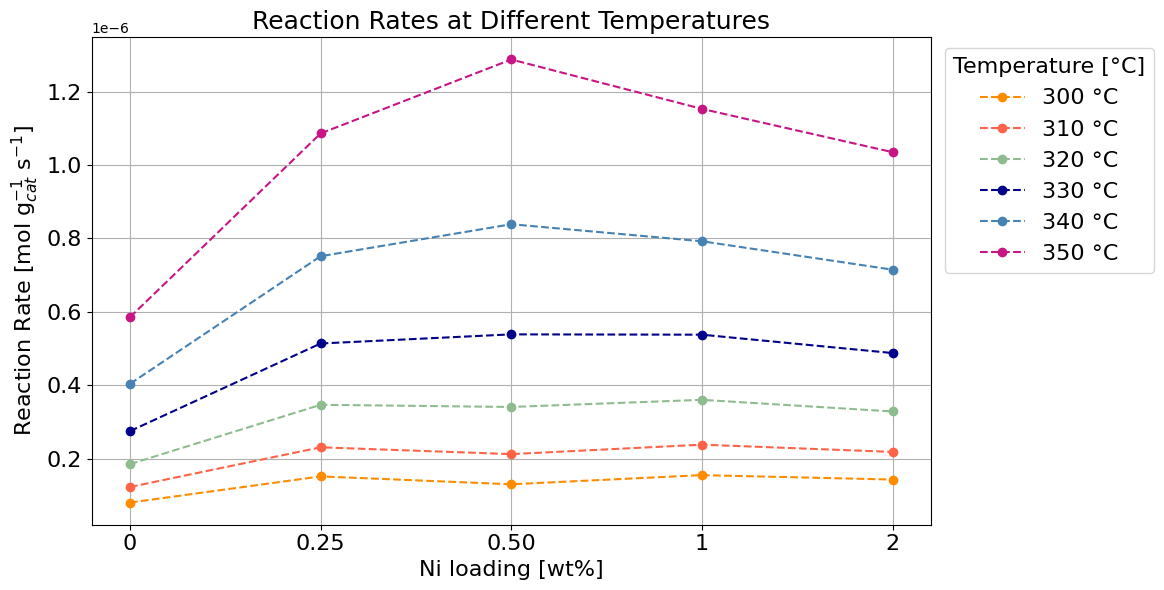

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

r_list_300 = [8.011377783056816e-08, 1.514175922323345e-07, 1.2991957407605808e-07, 1.5489386569733607e-07, 1.4284532093643752e-07]
r_list_310 = [1.2254155134354174e-07, 2.3069242272020057e-07, 2.1209912835650432e-07, 2.3786445538485215e-07, 2.18102549031952e-07]
r_list_320 = [1.8477190866339246e-07, 3.4651712305262695e-07, 3.4058519114394577e-07, 3.600338388551263e-07, 3.282904286161957e-07]
r_list_330 = [2.74836544126402e-07, 5.135197097658638e-07, 5.383840876828458e-07, 5.375117617141698e-07, 4.874911118137058e-07]
r_list_340 = [4.035416226149388e-07, 7.513066734910308e-07, 8.384399352242031e-07, 7.92055395089082e-07, 7.146186052013731e-07]
r_list_350 = [5.852592709402559e-07, 1.0858587909952113e-06, 1.2872925859426774e-06, 1.1527082020252e-06, 1.0347863991366922e-06]


sample_names =['0', '0.25', '0.50', '1', '2']

r_lists = [r_list_300, r_list_310, r_list_320, r_list_330, r_list_340, r_list_350]
temperatures = [300, 310, 320, 330, 340, 350]
colors = ['#f99d9d','#f5c0b6', 'palevioletred', '#f57979', '#f7be99', 'crimson']
colors = ['midnightblue', 'cornflowerblue', 'steelblue','lightblue','cadetblue', 'mediumturquoise']
colors = ['darkorange','tomato','darkseagreen','darkblue', 'steelblue','mediumvioletred']

title_fontsize = 18
label_fontsize = 16
tick_fontsize = 16
legend_fontsize = 16

plt.figure(figsize=(12, 6))

for i, r_list in enumerate(r_lists):
    plt.plot(sample_names, r_list, marker='o', label=f'{temperatures[i]} \u00b0C', color=colors[i], linestyle='--')

plt.xlabel('Ni loading [wt%]', fontsize=label_fontsize)
plt.ylabel('Reaction Rate [mol g$_{cat}^{-1}$ s$^{-1}$]', fontsize=label_fontsize)
plt.title('Reaction Rates at Different Temperatures', fontsize=title_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.legend(title='Temperature [\u00b0C]', fontsize=legend_fontsize, title_fontsize=legend_fontsize, loc='upper right', bbox_to_anchor=(1.28, 1))
plt.grid(True)
plt.tight_layout()
plt.show()


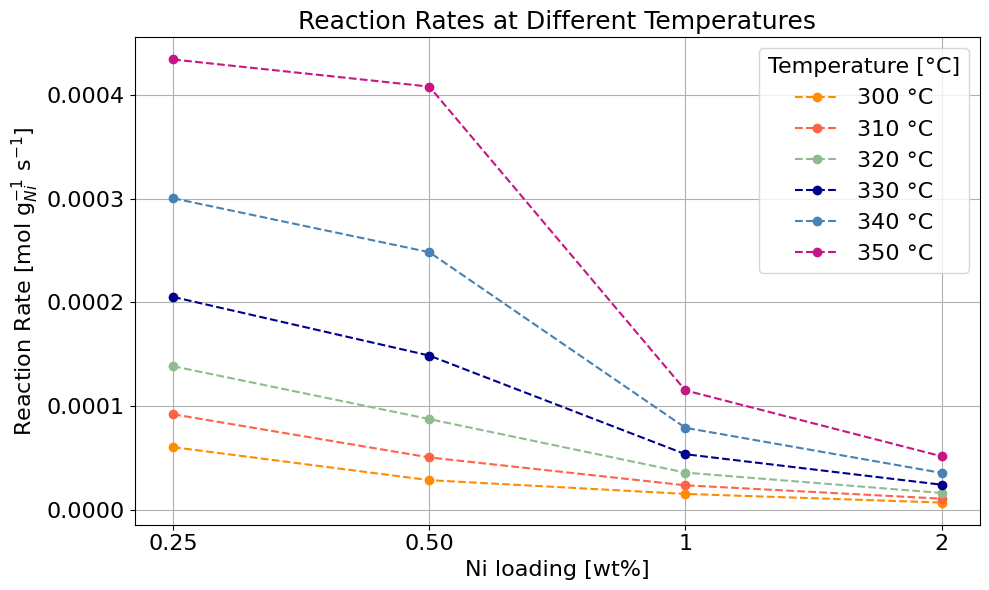

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

r_list_300_2 = [ 6.0554009856033975e-05, 2.872613089740316e-05, 1.5489386569733604e-05, 7.142266046821875e-06]
r_list_310_2 = [ 9.22571217331e-05, 5.065088861070132e-05, 2.3786445538485214e-05, 1.09051274515976e-05]
r_list_320_2 = [ 0.00013857703702233677, 8.76177012050195e-05, 3.600338388551263e-05, 1.6414521430809787e-05]
r_list_330_2 = [ 0.00020536370383381043, 0.000148834831672523, 5.375117617141698e-05, 2.437455559068529e-05]
r_list_340_2 = [ 0.0003004580315982915, 0.00024849141391718405, 7.92055395089082e-05, 3.5730930260068655e-05]
r_list_350_2 = [ 0.00043425009579662233, 0.0004081066091609, 0.00011527082020252, 5.1739319956834614e-05]


sample_names  =['0.25', '0.50', '1', '2']

r_lists = [r_list_300_2, r_list_310_2, r_list_320_2, r_list_330_2, r_list_340_2, r_list_350_2]
temperatures = [300, 310, 320, 330, 340, 350]
colors = ['#f99d9d','#f5c0b6', 'palevioletred', '#f57979', '#f7be99', 'crimson']
colors = ['midnightblue', 'cornflowerblue', 'steelblue','lightblue','cadetblue', 'mediumturquoise']
colors = ['darkorange','tomato','darkseagreen','darkblue', 'steelblue','mediumvioletred']


# Set font sizes
title_fontsize = 18
label_fontsize = 16
tick_fontsize = 16
legend_fontsize = 16

plt.figure(figsize=(10, 6))

for i, r_list in enumerate(r_lists):
    plt.plot(sample_names, r_list, marker='o', label=f'{temperatures[i]} \u00b0C', color=colors[i], linestyle='--')

plt.xlabel('Ni loading [wt%]', fontsize=label_fontsize)
plt.ylabel('Reaction Rate [mol g$_{Ni}^{-1}$ s$^{-1}$]', fontsize=label_fontsize)
plt.title('Reaction Rates at Different Temperatures', fontsize=title_fontsize)
plt.xticks(fontsize=tick_fontsize)
plt.yticks(fontsize=tick_fontsize)
plt.legend(title='Temperature [\u00b0C]', fontsize=legend_fontsize, title_fontsize=legend_fontsize, loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


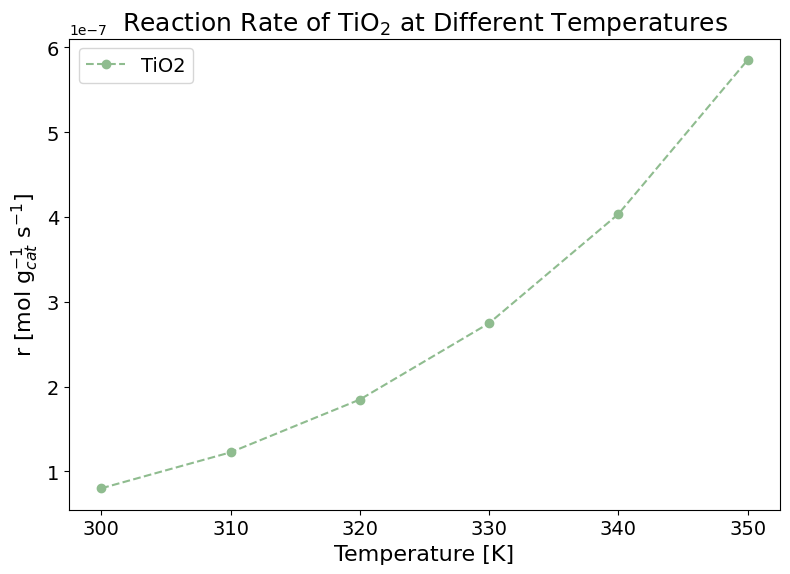

In [ ]:
import matplotlib.pyplot as plt

# List of TiO2 reaction rates
TiO2_r = [8.011377783056816e-08, 1.2254155134354174e-07, 1.8477190866339246e-07, 2.74836544126402e-07, 4.035416226149388e-07, 5.852592709402559e-07]

# Corresponding temperatures
temperatures = [300, 310, 320, 330, 340, 350]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(temperatures, TiO2_r, marker='o', linestyle='--', color='darkseagreen', label='TiO2')

# Labels and title
plt.xlabel('Temperature [K]', fontsize=16)
plt.ylabel('r [mol g$_{cat}^{-1}$ s$^{-1}$]', fontsize=16)
plt.title('Reaction Rate of TiO$_2$ at Different Temperatures', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

# Show plot
plt.tight_layout()
plt.show()
